<a href="https://colab.research.google.com/github/PCBZ/CS6180-Course/blob/main/HW2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2-Q1: [NLP] Performing Sentiment Analysis on Tweets
---

**Objective:**
Implement and evaluate machine learning models for sentiment analysis on Twitter data, exploring both traditional Bag-of-Words (BoW) and domain-specific feature engineering approaches.

**Learning Goals:**
- Master text preprocessing techniques and feature extraction for NLP tasks
- Implement and compare different feature engineering approaches (BoW vs domain-specific)  
- Understand logistic regression for binary text classification
- Learn to evaluate and analyze model performance through error analysis
- Gain hands-on experience with real-world social media data

In this homework, we will:
1. Process and clean Twitter data using NLTK
2. Design and extract features using BoW and sentiment-based approaches
3. Train logistic regression models for sentiment classification
4. Evaluate model performance using standard metrics
5. Analyze model errors to understand limitations and potential improvements

# Part 0: Getting started

## [Optional step] Mount at google drive (Only run this if you are using Colab)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys

# change this to your folder where utils.py located
folder_path = "/content/drive/MyDrive/NEU/CS6180/HW2"
sys.path.append(folder_path)

from utils import process_tweet, build_freqs

In [4]:
import sys

# change this to your folder where utils.py located
folder_path = "/content" # <--- Update this path if necessary
sys.path.append(folder_path)



from utils import process_tweet, build_freqs

## Import functions and data

Download the data needed for this project. Check out the [documentation for the twitter_samples dataset](http://www.nltk.org/howto/twitter.html).

* twitter_samples: if you're running this notebook on your local computer, you will need to download it using:
```Python
nltk.download('twitter_samples')
```

* stopwords: if you're running this notebook on your local computer, you will need to download it using:
```python
nltk.download('stopwords')
```

Let's import some helper functions that we provided in the utils.py file:
* `process_tweet()`: cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.
* `build_freqs()`: this counts how often a word in the 'corpus' (the entire set of tweets) was associated with a positive label '1' or a negative label '0', then builds the `freqs` dictionary, where each key is a (word,label) tuple, and the value is the count of its frequency within the corpus of tweets.

In [5]:
%pip install numpy
%pip install pandas
%pip install nltk
import nltk
from os import getcwd
import numpy as np
import pandas as pd
import random
from nltk.corpus import twitter_samples

from utils import process_tweet, build_freqs

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Part 1: Data Preparation
### Prepare the data
* The `twitter_samples` contains subsets of 5,000 positive tweets, 5,000 negative tweets, and the full set of 10,000 tweets.  
* If we used all three datasets, we would introduce duplicates of the positive tweets and negative tweets.  
* we will select just the five thousand positive tweets and five thousand negative tweets.
* Train test split: 30% will be in the test set, and 80% in the training set.
* Create the numpy array of positive labels and negative labels.


In [6]:
from sklearn.model_selection import train_test_split

# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Combine positive and negative tweets and create labels
X = all_positive_tweets + all_negative_tweets
y = np.append(np.ones((len(all_positive_tweets), 1)), np.zeros((len(all_negative_tweets), 1)), axis=0)

# Split the data while maintaining class proportions
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("train_y shape:", train_y.shape)
print("test_y shape:", test_y.shape)

train_y shape: (7000, 1)
test_y shape: (3000, 1)


* Create the frequency dictionary using the imported `build_freqs()` function.  

```Python
    for y,tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
```
* Notice how the outer for loop goes through each tweet, and the inner for loop steps through each word in a tweet.
* The `freqs` dictionary is the frequency dictionary that's being built.
* The key is the tuple (word, label), such as ("happy",1) or ("happy",0).  The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.

In [7]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

print("Sample entries:")
for key, value in list(freqs.items())[:15]:  # Print first 10 entries
    print(f"{key}: {value}")

type(freqs) = <class 'dict'>
len(freqs) = 11369
Sample entries:
('rm35', 1.0): 1
('still', 1.0): 30
('negooo', 1.0): 1
('male', 1.0): 1
(':)', 1.0): 2495
('movie', 0.0): 16
('marathon', 0.0): 3
('anyonneee', 0.0): 1
(':(', 0.0): 3171
('loner', 0.0): 1
('af', 0.0): 11
('might', 0.0): 5
(':-(', 0.0): 367
('mum', 0.0): 9
('stop', 0.0): 26


In [8]:
# Let's check frequency of a particular word (appearing in both positive and negative twitts)
love_positive_count = freqs.get(('love', 1.0), 0)  # Default to 0 if not found
love_negative_count = freqs.get(('love', 0.0), 0)

print(f"'love' in positive examples: {love_positive_count}")
print(f"'love' in negative examples: {love_negative_count}")

'love' in positive examples: 211
'love' in negative examples: 96


### Process tweet
The given function `process_tweet()` tokenizes the tweet into individual words, removes stop words and applies stemming.

In [9]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[1])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[1]))

This is an example of a positive tweet: 
 Movie marathon anyonneeee :(((( loner af

This is an example of the processed version of the tweet: 
 ['movie', 'marathon', 'anyonneee', ':(', 'loner', 'af']


# Part 2: Feature Design (Bag-of-Words (BoW) Approach)

### [TO DO] 2.1 Feature Design
Implement Bag-of-Words Feature Extraction

Implement the `extract_bow_features` function that takes a tweet text and vocabulary dictionary as input, and returns a feature vector representing the Bag-of-Words encoding.

The function should:
1. Process the tweet using the provided `process_tweet()` function
2. Create a feature vector of zeros with length equal to vocabulary size
3. For each word in the processed tweet, increment the corresponding position in the feature vector if the word exists in vocabulary
4. Return the feature vector

Your implementation will be used to create training and test features for sentiment classification.

In [10]:
def extract_bow_features(tweet, vocab):
    """
    Extract Bag-of-Words features for a single tweet.

    Args:
        tweet (str): The tweet text.
        vocab (dict): Dictionary mapping words to indices.

    Returns:
        np.ndarray: Feature vector of word frequencies.
    """
    # Clean and tokenize the tweet
    preprocessed_tweet = process_tweet(tweet)

    # Create a feature vector of zeros with length equal to vocabulary size
    x = np.zeros(len(vocab))

    # For each word in the processed tweet, increment its count if in vocabulary
    for word in preprocessed_tweet:
        if word in vocab:
            x[vocab[word]] += 1

    return x

### Now let's build a vocabulary dictionary from tweets

**Process:**
- Collect unique words across all tweets
- Create word-to-index mapping

**Why it's needed:**
- For feature extraction
- Converting text to numerical format
- Essential for machine learning models

In [11]:
# Let's build a vocabulary dictionary from tweets
unique_words = set()
for tweet in train_x:
    unique_words.update(process_tweet(tweet))
vocab_dict = {word: idx for idx, word in enumerate(unique_words)}

### Vocabulary Exploration and Analysis:

The feature extraction is now set up to create a Bag-of-Words representation for each tweet. Let's examine the vocabulary and most common words in the dataset to better understand what features our model will be using.
We'll look at:
1. Total vocabulary size
2. Most common positive and negative words
3. LEt's see fearures geenrated for an example tweets and vocab

This will help us understand what signal the models are picking up from the text data.


In [12]:
from collections import Counter

# Count the frequency of each word in the vocabulary
word_freq = Counter({word: freqs.get((word, 1), 0) + freqs.get((word, 0), 0) for word in vocab_dict.keys()})

# Get the top 5 most frequent words
top_5_words = word_freq.most_common(5)

print("Vocabulary size:", len(vocab_dict))

print("Top 5 most frequent words in the vocabulary:")
for word, freq in top_5_words:
    print(f"{word}: {freq}")

Vocabulary size: 9197
Top 5 most frequent words in the vocabulary:
:(: 3171
:): 2497
:-): 487
:D: 460
...: 432


In [13]:
# Use a small example vocabulary for demonstration
example_vocab = ['happy', 'sad', 'movie', 'great']  # Example vocabulary
example_vocab_dict = {word: idx for idx, word in enumerate(example_vocab)}

tweet = "I am happy, this movie is great"
print("Original tweet:", tweet)
print("Processed tweet:", process_tweet(tweet))
print("Vocabulary:", example_vocab)
print("Features:", extract_bow_features(tweet, example_vocab_dict))

Original tweet: I am happy, this movie is great
Processed tweet: ['happy', 'movie', 'great']
Vocabulary: ['happy', 'sad', 'movie', 'great']
Features: [1. 0. 1. 1.]


## 2.2 Modeling with Logistic Regression

Now that we have extracted the Bag-of-Words features, we'll build a Logistic Regression model for tweet sentiment classification.

- Logistic Regression is well-suited for classification problems like sentiment analysis (positive/negative)
- It's simple, and interpretable
- The model learns weights for each word feature to predict sentiment probability
- Uses sigmoid function to output probability between 0-1

#### Model Implementation
- Using scikit-learn's LogisticRegression class
- Training on BoW feature matrix X_bow (7000 samples × 8327 features)
- Binary target variable y (0=negative, 1=positive)
- Default hyperparameters with max_iter=100

In [14]:
%pip install scikit-learn

from sklearn.linear_model import LogisticRegression

# Extract features for training data
X_bow = np.array([extract_bow_features(tweet, vocab_dict) for tweet in train_x])
print("Shape of X_bow:", X_bow.shape)
print("Shape of each sample in X_bow:", X_bow[0].shape)

# Train the logistic regression model
model_bow = LogisticRegression(max_iter=100)
model_bow.fit(X_bow, train_y.ravel())


Shape of X_bow: (7000, 9197)
Shape of each sample in X_bow: (9197,)


LogisticRegression()

## 2.3 Evaluation

Let's test the model training on BoW features. You should be able to get see a very high Jaccard Index or IOU around 0.985!


In [15]:
from sklearn import metrics

def evaluate_model(model, test_x, test_y):
    """
    Evaluate the model using standard classification metrics.

    Args:
        model: Trained classifier.
        test_x (np.ndarray): Test feature matrix.
        test_y (np.ndarray): True labels for the test set.
    """
    y_hat = model.predict(test_x)
    print("\nClassification Report:")
    print(metrics.classification_report(test_y, y_hat))

    # Calculate Jaccard Index / IOU
    jaccard = metrics.jaccard_score(test_y, y_hat)
    print(f"\nJaccard Index or IOU: {jaccard:.4f}")

# Prepare test set features
X_bow_test = np.array([extract_bow_features(tweet, vocab_dict) for tweet in test_x])

# Evaluate the BoW model
evaluate_model(model_bow, X_bow_test, test_y)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1500
         1.0       0.99      1.00      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Jaccard Index or IOU: 0.9894


# Part 3: Domain-Specific Approach

First let's do a very brief analysis of the sparsity and dimensionality of the bag-of-words features obtained from tweets. This analysis would help understand how efficiently the feature representation captures the text data.

### Drawbacks of Bag-of-Words Approach

1. **Dimensionality & Sparsity**
    - High-dimensional feature space (8000+ features)
    - Most matrix entries are zero (>98% sparsity)
    - Computationally expensive to process

2. **Loss of Context**
    - Word order ignored
    - Negations mishandled
    - Phrase meaning lost ("not good" vs "good")

3. **Limited Semantics**
    - No word relationships captured
    - Synonyms treated as different features
    - No understanding of similar concepts

4. **Fixed Vocabulary**
    - Can't handle unseen words
    - Poor generalization
    - Domain-specific limitations

These limitations highlight why more advanced techniques like word embeddings and transformers have largely superseded BoW in modern NLP.


Total number of samples: 7,000
Total number of features (vocabulary size): 9,197
Matrix sparsity: 99.93%


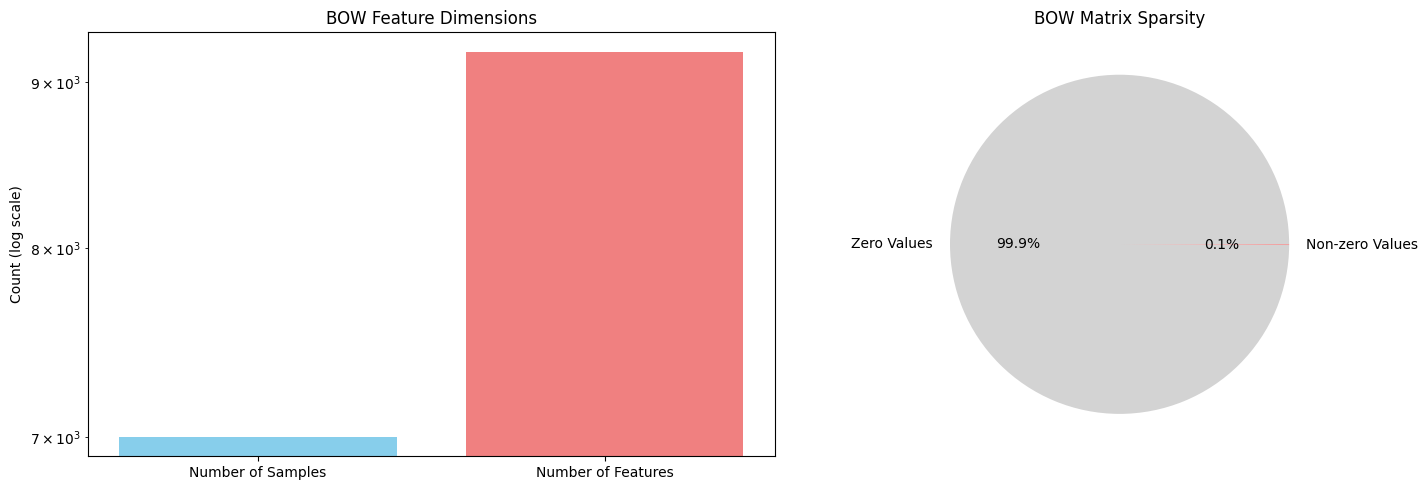

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

# Get dimensions of BOW features
n_samples, n_features = X_bow.shape

# Calculate sparsity (percentage of zero values)
sparsity = (X_bow == 0).sum() / (n_samples * n_features) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Visualize the dimensions
ax1.bar(['Number of Samples', 'Number of Features'], [n_samples, n_features], color=['skyblue', 'lightcoral'])
ax1.set_title('BOW Feature Dimensions')
ax1.set_yscale('log')  # Using log scale due to large difference
ax1.set_ylabel('Count (log scale)')

# Plot 2: Show sparsity
ax2.pie([sparsity, 100-sparsity], labels=['Zero Values', 'Non-zero Values'],
    colors=['lightgray', 'lightcoral'], autopct='%1.1f%%')
ax2.set_title('BOW Matrix Sparsity')

plt.tight_layout()
print(f"Total number of samples: {n_samples:,}")
print(f"Total number of features (vocabulary size): {n_features:,}")
print(f"Matrix sparsity: {sparsity:.2f}%")

## [TO DO] 3.1 Feature Design (Sentiment Approach)

* Given a list of tweets, extract the features and store them in a matrix. We will extract two features:
    * The first feature captures positive aspects of the words in a tweet (sum of total frequencies for each positive word in a tweet).
    * The second feature captures negative aspects of the words in a tweet (sum of total frequencies for each negative word in a tweet).
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set.

#### Task Instructions:
1. Process the tweet using the provided `process_tweet()` function to obtain a list of words.
2. Create a feature vector `x` of size 3:
    - \(x_0 = 1\) (bias term),
    - \(x_1 =\) sum of frequencies of positive words (label = 1),
    - \(x_2 =\) sum of frequencies of negative words (label = 0).
3. For each word in the tweet:
    - Add its frequency to \(x_1\) (positive sentiment).
    - Add its frequency to \(x_2\) (negative sentiment).
4. Return the feature vector \(x = [x_0, x_1, x_2]\).

The features will be used in the linear model:
$$
z = x_0 + x_1 \cdot \theta_1 + x_2 \cdot \theta_2
$$


# <details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Make sure you handle cases when the (word, label) key is not found in the dictionary. </li>
    <li> Search the web for hints about using the `.get()` method of a Python dictionary.  Here is an <a href="https://www.programiz.com/python-programming/methods/dictionary/get" > example </a> </li>
</ul>
</p>


In [17]:
def extract_sentiment_features(tweet, freqs):
    """
    Extract sentiment-based features for a single tweet.

    Args:
        tweet (str): The tweet text.
        freqs (dict): Dictionary of word frequencies by sentiment.

    Returns:
        np.ndarray: Feature vector with bias, positive, and negative frequencies.
    """
    words = process_tweet(tweet)
    # Bias + Positive + Negative
    x = np.zeros(3)
    x[0] = 1  # Bias term

    # Loop through each word in the list of words
    for word in words:
        x[1] += freqs.get((word, 1.0), 0)  # Positive sentiment
        x[2] += freqs.get((word, 0.0), 0)  # Negative sentiment

    return x

## 3.2: Modeling with Logistic Regression
To train the model:
* Stack the features for all training examples into a matrix `X`.
* Call `gradientDescent`, which we've implemented above.


***This section is completed for you. Please read it for understanding and run the cell.***



In [18]:
# Extract features for training data
X_sentiment = np.array([extract_sentiment_features(tweet, freqs) for tweet in train_x])

# Train the logistic regression model
model_sentiment = LogisticRegression(max_iter=100)
model_sentiment.fit(X_sentiment, train_y.ravel())

LogisticRegression()

## 3.3 Evaluation
Let's test the model training on sentiment-aware features. Again, you should be able to see a very high Jaccard Index or IOU around 0.985 (abotu the same as BoW)!


In [19]:
# Prepare test set features
X_sentiment_test = np.array([extract_sentiment_features(tweet, freqs) for tweet in test_x])

# Evaluate the sentiment-based model
evaluate_model(model_sentiment, X_sentiment_test, test_y)



Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1500
         1.0       0.99      1.00      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Jaccard Index or IOU: 0.9855


Total number of samples: 7,000
Total number of features (vocabulary size): 3
Matrix sparsity: 1.32%


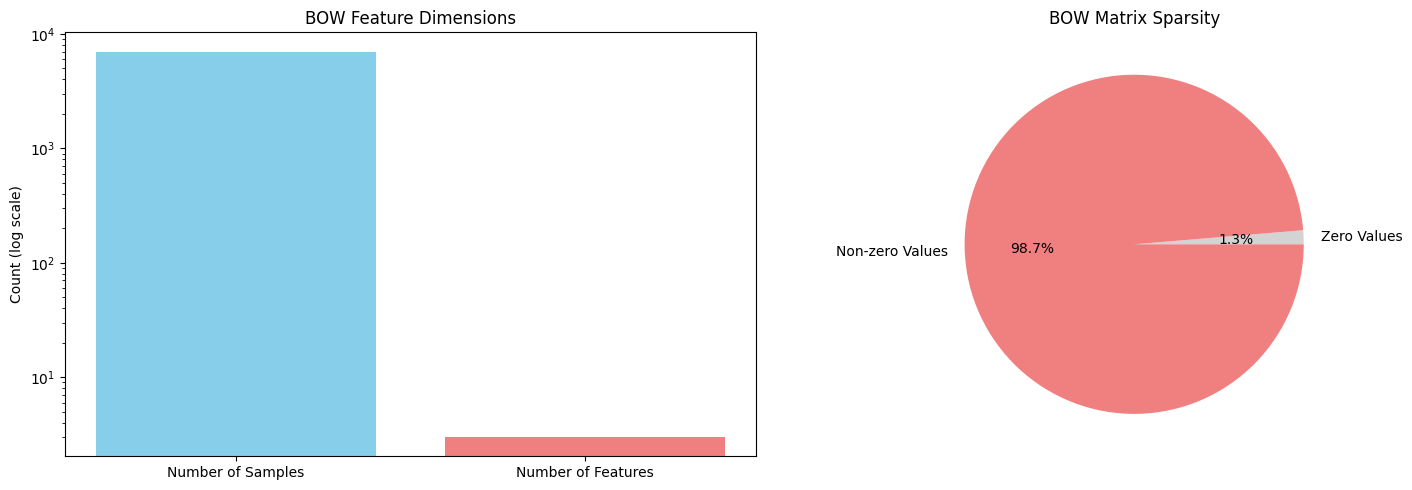

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt

# Get dimensions of BOW features
n_samples, n_features = X_sentiment.shape

# Calculate sparsity (percentage of zero values)
sparsity = (X_sentiment == 0).sum() / (n_samples * n_features) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Visualize the dimensions
ax1.bar(['Number of Samples', 'Number of Features'], [n_samples, n_features], color=['skyblue', 'lightcoral'])
ax1.set_title('BOW Feature Dimensions')
ax1.set_yscale('log')  # Using log scale due to large difference
ax1.set_ylabel('Count (log scale)')

# Plot 2: Show sparsity
ax2.pie([sparsity, 100-sparsity], labels=['Zero Values', 'Non-zero Values'],
    colors=['lightgray', 'lightcoral'], autopct='%1.1f%%')
ax2.set_title('BOW Matrix Sparsity')

plt.tight_layout()
print(f"Total number of samples: {n_samples:,}")
print(f"Total number of features (vocabulary size): {n_features:,}")
print(f"Matrix sparsity: {sparsity:.2f}%")

# Part 4: TF-IDF Approach

### [TO DO] 4.1 Feature Design (TF-IDF Approach)

#### Transform Text Data Using TF-IDF:
1. Apply the **TF-IDF** (Term Frequency-Inverse Document Frequency) transformation to the dataset.
2. Use an existing library (e.g., `TfidfVectorizer` in `scikit-learn`) to compute the TF-IDF matrix.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Your Code Here (For 4.1 Feature Design (TF-IDF)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

train_X_transform = tfidf_vectorizer.fit_transform(train_x)
test_X_transform = tfidf_vectorizer.transform(test_x)

print(f"Shape of train_X_transform: {train_X_transform.shape}")
print(f"Shape of test_X_transform: {test_X_transform.shape}")


Shape of train_X_transform: (7000, 5000)
Shape of test_X_transform: (3000, 5000)


#### Train and Evaluate Model:
1. Train the logistic regression model using the TF-IDF features.
2. Evaluate its performance on the test set using metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **IoU/Jaccard**.

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, classification_report

# Your Code Here (Train and evalaute model)
model_tfidf = LogisticRegression(max_iter=100)
model_tfidf.fit(train_X_transform, train_y.ravel())

evaluate_model(model_tfidf, test_X_transform, test_y)




Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      1500
         1.0       0.78      0.76      0.77      1500

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000


Jaccard Index or IOU: 0.6215


#### Analyze the TF-IDF Matrix:
1. Visualize the **feature importance** (e.g., most influential words for positive and negative predictions).

Total number of samples: 7,000
Total number of features (vocabulary size): 5,000
Matrix sparsity: 99.93%


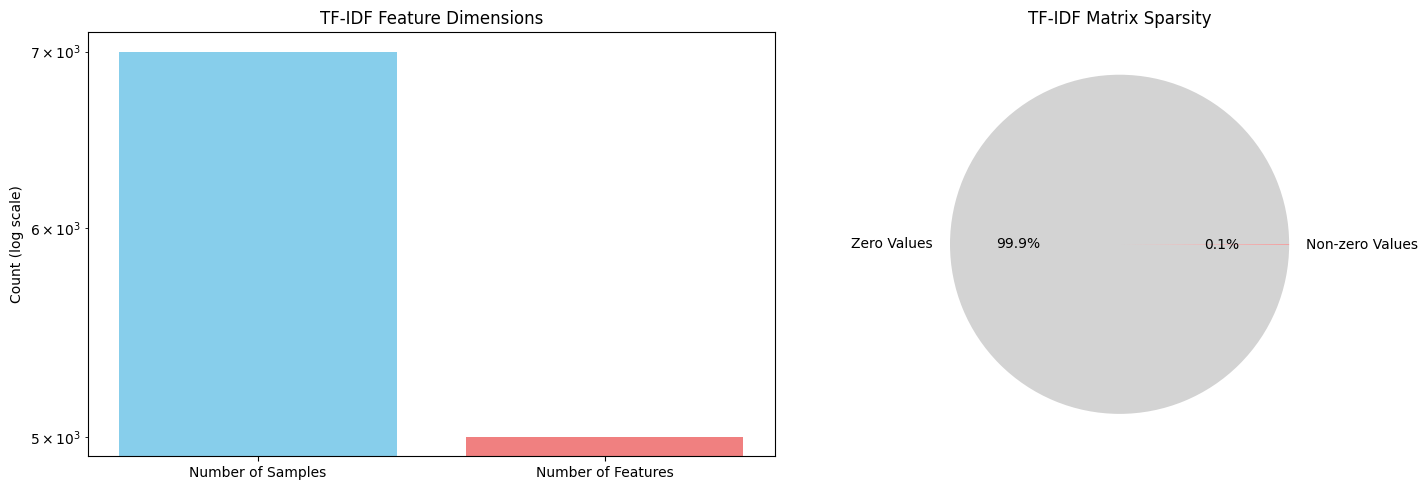

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your Code here (Analyze the TF-IDF Matrix)

n_samples, n_features = train_X_transform.shape

sparsity = (1 - test_X_transform.nnz / (n_samples * n_features)) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Visualize the dimensions
ax1.bar(['Number of Samples', 'Number of Features'], [n_samples, n_features], color=['skyblue', 'lightcoral'])
ax1.set_title('TF-IDF Feature Dimensions')
ax1.set_yscale('log')  # Using log scale due to large difference
ax1.set_ylabel('Count (log scale)')

# Plot 2: Show sparsity
ax2.pie([sparsity, 100-sparsity], labels=['Zero Values', 'Non-zero Values'],
    colors=['lightgray', 'lightcoral'], autopct='%1.1f%%')
ax2.set_title('TF-IDF Matrix Sparsity')

plt.tight_layout()
print(f"Total number of samples: {n_samples:,}")
print(f"Total number of features (vocabulary size): {n_features:,}")
print(f"Matrix sparsity: {sparsity:.2f}%")


# Part 5: Error Analysis

Let's compare these 3 approaches on some custome tweets.

In [24]:
# Function to test custom tweets and output probabilities
def test_custom_tweets(tweets, model, feature_extraction_func, **kwargs):
    """
    Test logistic regression model on custom tweets and output probabilities.

    Args:
        tweets (list of str): List of tweets to test.
        model (LogisticRegression): Trained logistic regression model.
        feature_extraction_func (function): Function to extract features.
        kwargs: Additional arguments for the feature extraction function.
    """
    for tweet in tweets:
        features = feature_extraction_func(tweet, **kwargs).reshape(1, -1)  # Prepare features
        prob = model.predict_proba(features)[0, 1]  # Positive class probability
        sentiment = 'Positive' if prob >= 0.5 else 'Negative'
        print(f"'{tweet}' -> {sentiment} ({prob:.4f})")

# Example custom tweets
custom_tweets = [
    'I am happy',
    'I am bad',
    'I do not love it but it is not too annoying either',
    'this movie should have been great.',
    'Who made this stupid movie?',
    'great',
    'not good',
    'not too bad',
    'great great',
    'great great great',
    'great great great great'
]

# Convert vocab list to dictionary
vocab_dict = {word: idx for idx, word in enumerate(unique_words)}

# Test with Bag-of-Words model
print("Testing BoW Model:")
test_custom_tweets(custom_tweets, model_bow, extract_bow_features, vocab=vocab_dict)

# Test with Sentiment-based model
print("\nTesting Sentiment-based Model:")
test_custom_tweets(custom_tweets, model_sentiment, extract_sentiment_features, freqs=freqs)

Testing BoW Model:
'I am happy' -> Positive (0.7783)
'I am bad' -> Positive (0.6565)
'I do not love it but it is not too annoying either' -> Positive (0.6939)
'this movie should have been great.' -> Positive (0.7995)
'Who made this stupid movie?' -> Positive (0.7374)
'great' -> Positive (0.8035)
'not good' -> Positive (0.7547)
'not too bad' -> Positive (0.6565)
'great great' -> Positive (0.8641)
'great great great' -> Positive (0.9082)
'great great great great' -> Positive (0.9389)

Testing Sentiment-based Model:
'I am happy' -> Positive (0.8956)
'I am bad' -> Positive (0.6178)
'I do not love it but it is not too annoying either' -> Positive (0.8737)
'this movie should have been great.' -> Positive (0.8953)
'Who made this stupid movie?' -> Positive (0.7769)
'great' -> Positive (0.9012)
'not good' -> Positive (0.8801)
'not too bad' -> Positive (0.6178)
'great great' -> Positive (0.9659)
'great great great' -> Positive (0.9888)
'great great great great' -> Positive (0.9964)



### [TO DO] 5.1 Error Analysis, Comparison and Reflection

1. **Consolidate Results**:
   - Compare these methods by briefly discussing the strengths and weaknesses of each feature extraction approach. If you're considering performance, only look at **F1-score**, and **IoU/Jaccard** metrics as other can be confusing.

2. **Review Misclassified Tweets**:
   - Compare the tweets misclassified by each model to identify patterns or trends in the errors (e.g., sarcasm, negations, uncommon phrases).
   - Reflect on the limitations of the models and suggest improvements.

Error Analysis for BoW Model:

Error Analysis:
Misclassified Tweet: 'Zehr khany ka time is coming soon.....: ('
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: 'Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs #Job #Jobs #Hiring'
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: '@bae_ts WHATEVER STIL L YOUNG &gt;:-('
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: 'Screenshots from http://t.co/U2RdUgq6wH there's a competition open to meet ariana grande some countries excluded :( http://t.co/OdI14ms8NR'
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: '@PSYCRM you still haven't ! ! : ('
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: '@JindalDaily praying for you all. So sorry this happened : ('
True Label: [0.], Predicted Label: 1.0

Misclassified Tweet: '@OTRJSJ offers you my mixtape. will you talk to me more now : ( suckmejimin.'
True Label: [0.], Predicted Label: 1.0

Mi

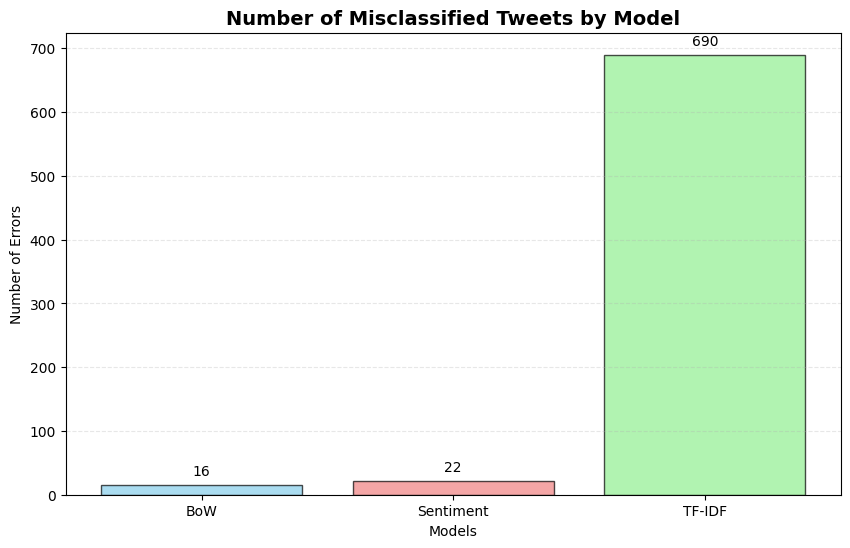

In [30]:
def error_analysis(test_x, test_y, model, feature_extraction_func, **kwargs):
    """
    Perform error analysis by identifying misclassified tweets.

    Args:
        test_x (list of str): Test set tweets.
        test_y (np.ndarray): True labels for the test set.
        model (LogisticRegression): Trained logistic regression model.
        feature_extraction_func (function): Function to extract features.
        kwargs: Additional arguments required by the feature extraction function.
    """
    print("\nError Analysis:")

    missclassified_tweets = []

    for tweet, true_label in zip(test_x, test_y):

        if kwargs: # BoW or Sentiment
            features = feature_extraction_func(tweet, **kwargs)
            features = features.reshape(1, -1)  # Reshape for sklearn compatibility
        else: # TF-IDF
            features = feature_extraction_func([tweet])

        pred_label = model.predict(features)[0]

        if pred_label != true_label:
            missclassified_tweets.append((tweet, true_label, pred_label))
            print(f"Misclassified Tweet: '{tweet}'")
            print(f"True Label: {true_label}, Predicted Label: {pred_label}\n")

    return missclassified_tweets

# Convert vocab list to dictionary
vocab_dict = {word: idx for idx, word in enumerate(unique_words)}

# Perform error analysis
print("Error Analysis for BoW Model:")
bow_errors = error_analysis(test_x, test_y, model_bow, extract_bow_features, vocab=vocab_dict)

print("\nError Analysis for Sentiment-based Model:")
senti_errors = error_analysis(test_x, test_y, model_sentiment, extract_sentiment_features, freqs=freqs)

# Perform TF-IDF error analysis
print("\nError Analysis for TF-IDF Model:")
tfidf_errors = error_analysis(test_x, test_y, model_tfidf, tfidf_vectorizer.transform)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

models = ["BoW", "Sentiment", "TF-IDF"]
error_counts = [len(bow_errors), len(senti_errors), len(tfidf_errors)]
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.bar(models, error_counts, color=colors, alpha=0.7, edgecolor='black')

for i, v in enumerate(error_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.title('Number of Misclassified Tweets by Model', fontsize=14, fontweight='bold')
plt.ylabel('Number of Errors')
plt.xlabel('Models')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

